In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
usage_df = pd.read_csv('santa_barb_c.csv')

In [3]:
usage_df.head()

,ZipCode,County,Month,Year,CustomerClass,TotalkWh,TotalGWh
0,93013,Santa Barbara County,1,2015,Residential,3407942.0,3.407942
1,93013,Santa Barbara County,1,2015,Commercial,3993698.0,3.993698
2,93013,Santa Barbara County,1,2015,Agricultural,2398433.0,2.398433
3,93067,Santa Barbara County,1,2015,Residential,312060.0,0.312060
4,93101,Santa Barbara County,1,2015,Residential,4144888.0,4.144888


In [4]:
usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2494 entries, 0 to 2493
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ZipCode        2494 non-null   int64  
 1   County         2494 non-null   object 
 2   Month          2494 non-null   int64  
 3   Year           2494 non-null   int64  
 4   CustomerClass  2494 non-null   object 
 5   TotalkWh       2494 non-null   float64
 6   TotalGWh       2494 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 136.5+ KB


In [5]:
# Creating GWh field from converting kWh
usage_df['TotalGWh'] = usage_df['TotalkWh'] / 1000000

In [6]:
# Creating 'Date' column to combine Month and Year
usage_df['Date'] = usage_df['Month'].astype(str) + '-' + usage_df['Year'].astype(str)

In [7]:
usage_df['Date'] = pd.to_datetime(usage_df['Date'], format='%m-%Y')

In [8]:
usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2494 entries, 0 to 2493
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ZipCode        2494 non-null   int64         
 1   County         2494 non-null   object        
 2   Month          2494 non-null   int64         
 3   Year           2494 non-null   int64         
 4   CustomerClass  2494 non-null   object        
 5   TotalkWh       2494 non-null   float64       
 6   TotalGWh       2494 non-null   float64       
 7   Date           2494 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 156.0+ KB


In [9]:
# Setting 'Date' as the index
usage_df = usage_df.set_index('Date')

In [10]:
usage_df.head()

,ZipCode,County,Month,Year,CustomerClass,TotalkWh,TotalGWh
Date,,,,,,,
2015-01-01,93013,Santa Barbara County,1,2015,Residential,3407942.0,3.407942
2015-01-01,93013,Santa Barbara County,1,2015,Commercial,3993698.0,3.993698
2015-01-01,93013,Santa Barbara County,1,2015,Agricultural,2398433.0,2.398433
2015-01-01,93067,Santa Barbara County,1,2015,Residential,312060.0,0.312060
2015-01-01,93101,Santa Barbara County,1,2015,Residential,4144888.0,4.144888


## Resampling dataframe to total monthly usage

In [11]:
usage = usage_df[['TotalkWh','TotalGWh']].resample('M').sum()

In [12]:
usage.head()

,TotalkWh,TotalGWh
Date,,
2015-01-31,85285224.0,85.285224
2015-02-28,105280208.0,105.280208
2015-03-31,75298583.0,75.298583
2015-04-30,81079816.0,81.079816
2015-05-31,78968054.0,78.968054


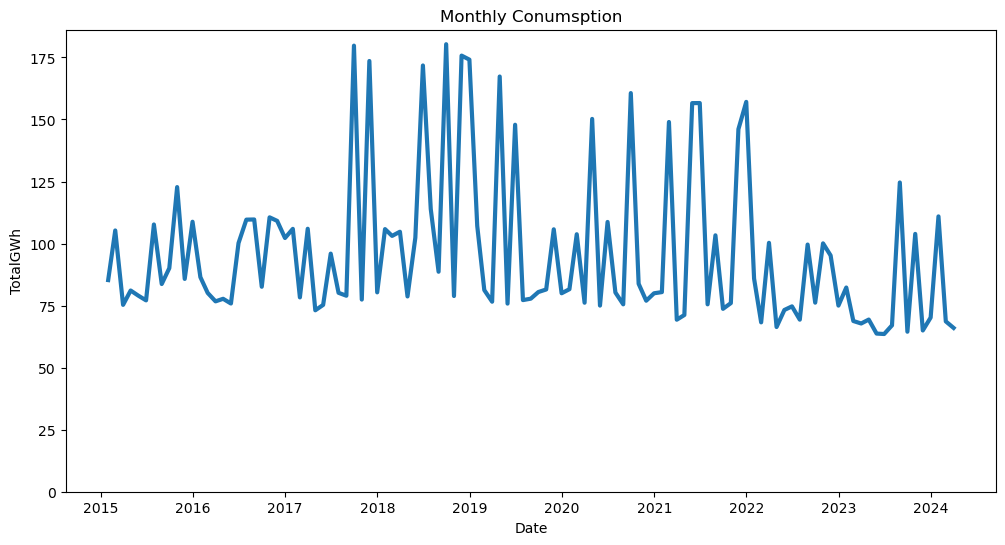

In [13]:
# PLotting data
plt.figure(figsize=(12, 6))
plt.plot(usage['TotalGWh'], linewidth=3)
plt.title("Monthly Conumsption")
plt.xlabel("Date")
plt.ylabel("TotalGWh")
plt.ylim(ymin=0)
plt.show()

## Implementing SARIMA model

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [15]:
# Checking for stationarity of data

def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')
 
 
check_stationarity(usage['TotalGWh'])

ADF Statistic: -10.484315931608114
p-value: 1.191270591579959e-18
Stationary


***SARIMAX model can still handle non-stationary data***

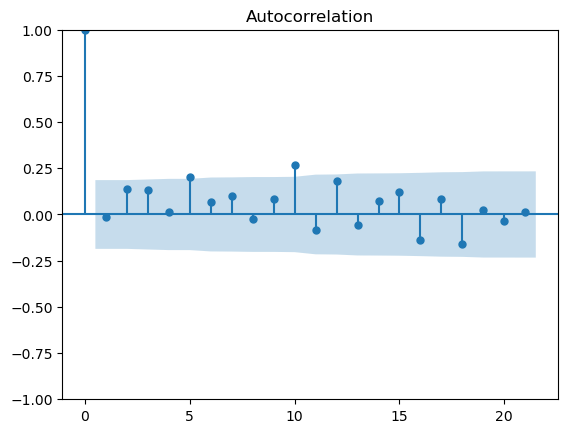

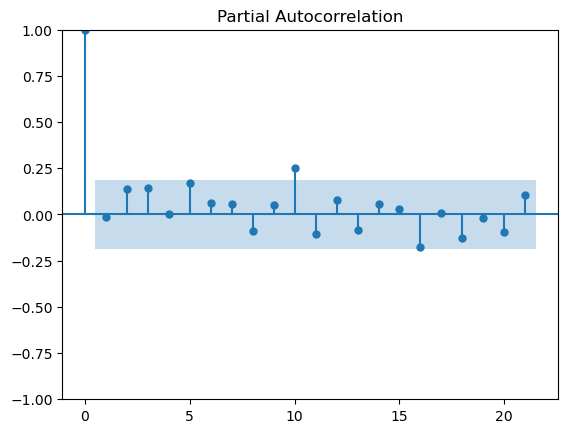

In [16]:
 # Plot ACF and PACF
plot_acf(usage['TotalGWh'])
plot_pacf(usage['TotalGWh'])
plt.show()

## Using AutoArima to find the parameters for SARIMAX model

In [17]:
# Install the library if necessary
# !pip install pmdarima

# Import the library
from pmdarima.arima import auto_arima

# Build and fit the AutoARIMA model
model = auto_arima(usage['TotalGWh'],
                   test='adf',
                   seasonal=True,
                   #max_p=3, max_q=3,
                   start_p=0,
                   d=1,
                   trace=True,
                   start_P=0,
                   m=12,
                   #D=None,
                   stepwise=True,
                   with_intercept=True,
                   suppress_warnings=True)

model.fit(usage['TotalGWh'])

# Check the model summary
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=1068.823, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1144.828, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1104.311, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1067.637, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1142.830, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1068.650, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=1068.205, Time=0.45 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1068.161, Time=0.19 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1138.361, Time=0.10 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=1068.837, Time=0.20 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1104.112, Time=0.14 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=1070.823, Time=0.36 sec
 ARIMA(0,1,1)(0,0,1)[12]     

In [18]:
# p, d, q parameters
model.order

(0, 1, 1)

In [19]:
# P, D, Q, s parameters
model.seasonal_order

(0, 0, 1, 12)

In [20]:
# Define SARIMA parameters from AutoArima results

# Fit the SARIMA model
model = SARIMAX(usage['TotalGWh'], order=model.order, seasonal_order=model.seasonal_order)
results = model.fit()
model

### Forecasting the next 12 months

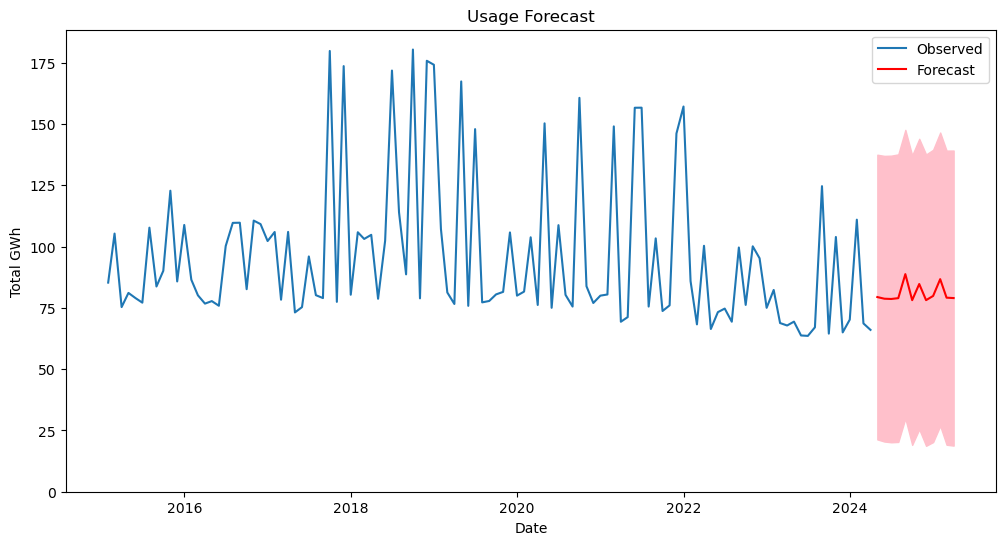

In [21]:
# Forecast future demand
forecast_periods = 12  # Forecast the next 12 months
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
 
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(usage['TotalGWh'], label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Usage Forecast")
plt.xlabel("Date")
plt.ylabel("Total GWh")
plt.ylim(bottom=0)
plt.legend()
plt.show()

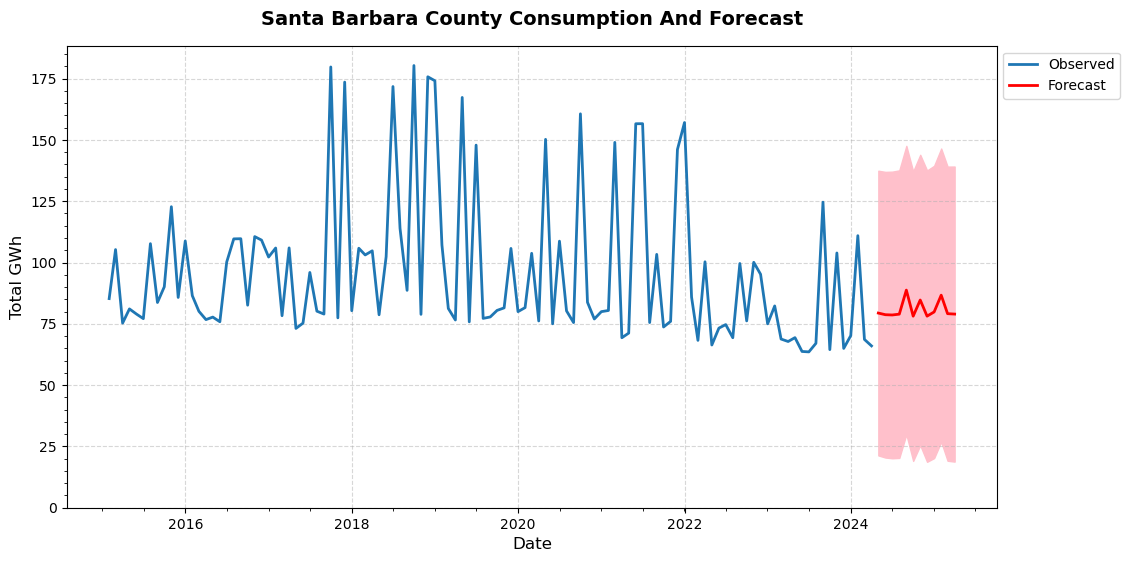

In [22]:
# Alternative Plot
from matplotlib.ticker import AutoMinorLocator


# Plot settings
plt.figure(figsize=(13, 6))
ax1 = sns.lineplot(data=usage['TotalGWh'], label='Observed',linewidth=2)
ax2 = sns.lineplot(data=forecast_mean, label='Forecast', color='red', linewidth=2)

# Fill between forecast confidence intervals
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')


# Plot labels and legend
plt.title("Santa Barbara County Consumption And Forecast", weight='bold', fontsize=14, pad=15)
plt.xlabel("Date",fontsize=12)
plt.ylabel("Total GWh",fontsize=12)
plt.ylim(bottom=0)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.13,1), loc='upper right')

# Show plot
plt.show()

### Evaluate Model

In [23]:
observed = usage['TotalGWh'][-forecast_periods:]
mae = mean_absolute_error(observed, forecast_mean)
mse = mean_squared_error(observed, forecast_mean)
rmse = np.sqrt(mse)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 15.933630883192597
MSE: 305.6376856278791
RMSE: 17.482496550203553


In [24]:
observed

Date
2023-04-30     69.371355
2023-05-31     63.729866
2023-06-30     63.556355
2023-07-31     67.047044
2023-08-31    124.621407
2023-09-30     64.478485
2023-10-31    103.894350
2023-11-30     64.980712
2023-12-31     70.191579
2024-01-31    110.951998
2024-02-29     68.640159
2024-03-31     66.001075
Freq: M, Name: TotalGWh, dtype: float64

In [25]:
forecast_mean

2024-04-30    79.388736
2024-05-31    78.717730
2024-06-30    78.609652
2024-07-31    78.945275
2024-08-31    88.746733
2024-09-30    78.128070
2024-10-31    84.712581
2024-11-30    78.132306
2024-12-31    79.848855
2025-01-31    86.693979
2025-02-28    79.139262
2025-03-31    78.975853
Freq: M, Name: predicted_mean, dtype: float64

In [30]:
customer_consum = usage_df.groupby('CustomerClass')['TotalGWh'].sum()
customer_consum

CustomerClass
Agricultural     541.572391
Commercial      4488.227524
Industrial      2081.719452
Residential     3561.123317
Name: TotalGWh, dtype: float64

In [31]:
customer_df = customer_consum.reset_index()
customer_df

,CustomerClass,TotalGWh
0,Agricultural,541.572391
1,Commercial,4488.227524
2,Industrial,2081.719452
3,Residential,3561.123317


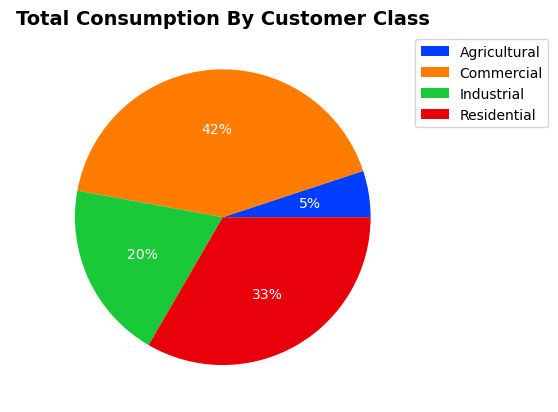

In [32]:
# With Percentages

# Plotting Total GWh usage per customer type
palette_color = sns.color_palette("bright") 
plt.pie(customer_df['TotalGWh'], labels=customer_df['CustomerClass']
       ,colors=palette_color, autopct='%.0f%%', textprops=dict(color='w'))
plt.title('Total Consumption By Customer Class', fontsize=14, weight='bold', loc='Center')
plt.legend(customer_df['CustomerClass'], loc='upper right',bbox_to_anchor=(0.9,0,0.5, 1))
plt.show()

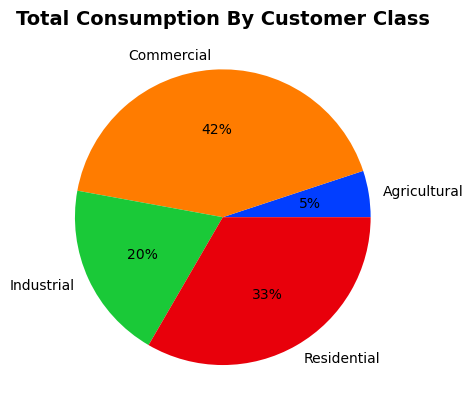

In [33]:
# With Percentages

# Plotting Total GWh usage per customer type
palette_color = sns.color_palette("bright") 
plt.pie(customer_df['TotalGWh'], labels=customer_df['CustomerClass']
       ,colors=palette_color, autopct='%.0f%%', textprops=dict(color='black'))
plt.title('Total Consumption By Customer Class', fontsize=14, weight='bold', loc='Center')
#plt.legend(customer_df['CustomerClass'], loc='upper right',bbox_to_anchor=(0.9,0,0.5, 1))
plt.show()

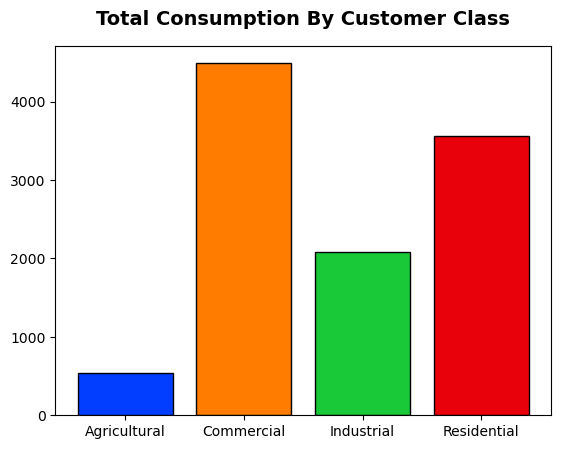

In [34]:
# Bar chart
plt.bar(customer_df['CustomerClass'],customer_df['TotalGWh'], color=palette_color,edgecolor='black', )
plt.title('Total Consumption By Customer Class', fontsize=14, weight='bold', loc='Center', pad=15)
plt.show()